In [1]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install glob2

In [2]:
!pip install pandas

In [3]:
!pip install numpy

In [4]:
!pip install imageio

In [5]:
!pip install urllib3

In [1]:
# Necessary imports
import glob
import pandas as pd
import urllib.request
import imageio
import os
import numpy as np

from urllib.request import urlopen

In [2]:
# Load Glove Function
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r',encoding="utf8")
    model = {}
    for line in f:
        try:
            splitLine = line.split()
            word = splitLine[0]
            embedding = np.array([float(val) for val in splitLine[1:]])
            model[word] = embedding
        except:
            print(word)
    print("Done.",len(model)," words loaded!")
    return model

In [3]:
glove_embeddings = loadGloveModel("glove.6B.300d.txt")

Loading Glove Model
Done. 400000  words loaded!


In [4]:
# Setting up the paths
train_data_path = "flowers"
train_images_path = "flowers/images/jpg"
train_captions_path = "flowers/text_c10"

In [10]:
!pip install tensorflow

In [11]:
!pip install matplotlib

In [12]:
!pip install tqdm

In [13]:
!pip install scikit-learn

The following packages will be used to implement a basic GAN system in Python/Keras.

In [5]:
# Imports
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Concatenate 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers
from sklearn.metrics import mean_squared_error

import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

2023-03-28 19:32:34.093653: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-28 19:32:34.095096: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-28 19:32:34.095106: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [6]:
# Formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [7]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
GENERATE_RES = 2 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100
EMBEDDING_SIZE = 300

# Configuration
DATA_PATH = train_images_path
MODEL_PATH = "flowers/model"
EPOCHS = 50
BATCH_SIZE = 64
BUFFER_SIZE = 4000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 64px square images.


## Data Pre-Processing 

Next we will load and preprocess the images.  This can take awhile.  Google CoLab took around an hour to process.  Because of this we store the processed file as a binary.  This way we can simply reload the processed training data and quickly use it.  It is most efficient to only perform this operation once.  The dimensions of the image are encoded into the filename of the binary file because we need to regenerate it if these change.

In [8]:
len(os.listdir(DATA_PATH))

8189

In [9]:
# Image set has 8,188 images.  Can take over an hour 
# for initial preprocessing.
# Because of this time needed, save a Numpy preprocessed file.

training_binary_path = os.path.join("flowers/images/npy64",
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}_')

start = time.time()
print("Loading training images...")

training_data = []
flowers_path = sorted(os.listdir(DATA_PATH))

for filename in range(len(flowers_path)):
    path = os.path.join(DATA_PATH,flowers_path[filename])
    # print(path)
    try:
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      channel = np.asarray(image).shape[2]
      if channel == 3:
        training_data.append(np.asarray(image))
    except KeyboardInterrupt:
        print("Keyboard Interrup by me...")
        break
    except:
      pass
    if len(training_data) == 100:
      training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
                GENERATE_SQUARE,IMAGE_CHANNELS))
      training_data = training_data.astype(np.float32)
      #Normalizing the input
      training_data = training_data / 127.5 - 1.

      print("Saving training image " + str(100000 + filename) + ".npy")
      np.save(training_binary_path + str(100000 + filename) + ".npy",training_data)
      elapsed = time.time()-start
      print (f'Image preprocess time: {hms_string(elapsed)}')
      training_data = []
print("Complete")

Loading training images...


/tmp/ipykernel_86/1180419247.py:19: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  GENERATE_SQUARE),Image.ANTIALIAS)


Saving training image 100099.npy
Image preprocess time: 0:00:01.01
Saving training image 100199.npy
Image preprocess time: 0:00:01.92
Saving training image 100299.npy
Image preprocess time: 0:00:02.84
Saving training image 100399.npy
Image preprocess time: 0:00:03.73
Saving training image 100499.npy
Image preprocess time: 0:00:04.56
Saving training image 100599.npy
Image preprocess time: 0:00:05.38
Saving training image 100699.npy
Image preprocess time: 0:00:06.23
Saving training image 100799.npy
Image preprocess time: 0:00:06.99
Saving training image 100899.npy
Image preprocess time: 0:00:07.70
Saving training image 100999.npy
Image preprocess time: 0:00:08.47
Saving training image 101099.npy
Image preprocess time: 0:00:09.32
Saving training image 101199.npy
Image preprocess time: 0:00:10.15
Saving training image 101299.npy
Image preprocess time: 0:00:10.94
Saving training image 101399.npy
Image preprocess time: 0:00:11.71
Saving training image 101499.npy
Image preprocess time: 0:00:1

Next we will load and preprocess the captions. This can take awhile. Google CoLab took around an hour to process. Because of this we store the processed file as a binary. This way we can simply reload the processed data and quickly use it. It is most efficient to only perform this operation once.

In [10]:
text_path = "flowers/text_c10/captions"
text_files = sorted(os.listdir(text_path))
captions = []
caption_embeddings = np.zeros((len(text_files),300),dtype=np.float32)
for filename in range(len(text_files)):
    path = os.path.join(text_path,text_files[filename])
    # print(path)
    f = open(path,'r')
    data = f.read()
    data = data.split("\n")
    f.close()
    for d in range(1):
      x = data[d].lower()
      x = x.replace(" ","")
      captions.append(x)
      count = 0
      for t in x:
        try:
          caption_embeddings[filename] += glove_embeddings[t]
          count += 1
        except:
          print(t)
          pass
      caption_embeddings[filename] /= count
    if filename %100 == 0:
      print("-------------Files completed:",filename)

-------------Files completed: 0
-------------Files completed: 100
-------------Files completed: 200
-------------Files completed: 300
-------------Files completed: 400
-------------Files completed: 500
-------------Files completed: 600
-------------Files completed: 700
-------------Files completed: 800
-------------Files completed: 900
-------------Files completed: 1000
-------------Files completed: 1100
-------------Files completed: 1200
-------------Files completed: 1300
-------------Files completed: 1400
-------------Files completed: 1500
-------------Files completed: 1600
-------------Files completed: 1700
-------------Files completed: 1800
-------------Files completed: 1900
-------------Files completed: 2000
-------------Files completed: 2100
-------------Files completed: 2200
-------------Files completed: 2300
-------------Files completed: 2400
-------------Files completed: 2500
-------------Files completed: 2600
-------------Files completed: 2700
-------------Files completed: 28

In [11]:
# saving the caption embeddings numpy
embedding_binary_path = os.path.join('flowers/images/embedding_npy',
        f'embedding_data_character.npy')
# print("Saving captions embeddings binary...")
# np.save(embedding_binary_path,caption_embeddings)

In [12]:
# saving the caption embeddings numpy
embedding_binary_path = os.path.join('flowers/images/embedding_npy',
        f'embedding_data.npy')
print("Saving captions embeddings binary...")
np.save(embedding_binary_path,caption_embeddings)

Saving captions embeddings binary...


In [13]:
# Creating a dataframe to store the captions
df_captions = pd.DataFrame([])
df_captions['captions'] = captions[:200]

In [14]:
df_captions.head()

,captions
0,"prominentpurplestigma,petalsarewhiteincolor"
1,"thisflowerisblueandgreenincolor,withpetalsthat..."
2,"outerpetalsaregreenincolorandklarger,innerpeta..."
3,"thereareseveralshapes,sizes,andcolorsofpetalso..."
4,thestamenaretoweringoverthestigmawhichcannotbe...


In [15]:
captions[:10]

['prominentpurplestigma,petalsarewhiteincolor',
 'thisflowerisblueandgreenincolor,withpetalsthatareovalshaped.',
 'outerpetalsaregreenincolorandklarger,innerpetalsareneedleshaped',
 'thereareseveralshapes,sizes,andcolorsofpetalsonthiscomplexflower.',
 'thestamenaretoweringoverthestigmawhichcannotbeseen.',
 'thisfloweriswhiteandpurpleincolor,withpetalsthatareovalshaped.',
 'thepetalsofthisfloweraregreenwithalongstigma',
 'theblossomhasalayerofroundedpurpleandwhitepetalstoppedbyalayeroffringedpurplepetals.',
 'thisflowerispurpleandyellowincolor,withpetalsthatareovalshaped.',
 'thepetalsonthisflowerarewhitewithanelaboratepistil.']

In [16]:
df_captions.to_csv("flowers/text_c10/captions.csv",index=None)

## Loading and combining numpys

In [17]:
embedding_binary_path = os.path.join('flowers/images/embedding_npy',
        f'embedding_data.npy')

In [18]:
caption_embeddings = np.load(embedding_binary_path)

In [19]:
caption_embeddings.shape

(8189, 300)

In [20]:
#caption_embeddings = caption_embeddings[::5]

In [20]:
caption_embeddings.shape

(8189, 300)

In [21]:
image_binary_path = "flowers/images/npy64/"
images = os.listdir(image_binary_path)
print(len(images))

81


In [22]:
images[-1]

'training_data_64_64_108099.npy'

In [23]:
# Creating a list of all the preprocessed images
final_images = np.load(image_binary_path + images[0])
for i in images[1:]:
  print(i)
  try:
    final_images = np.concatenate([final_images,np.load(image_binary_path + i)],axis = 0)
  except:
    pass

training_data_64_64_100199.npy
training_data_64_64_100299.npy
training_data_64_64_100399.npy
training_data_64_64_100499.npy
training_data_64_64_100599.npy
training_data_64_64_100699.npy
training_data_64_64_100799.npy
training_data_64_64_100899.npy
training_data_64_64_100999.npy
training_data_64_64_101099.npy
training_data_64_64_101199.npy
training_data_64_64_101299.npy
training_data_64_64_101399.npy
training_data_64_64_101499.npy
training_data_64_64_101599.npy
training_data_64_64_101699.npy
training_data_64_64_101799.npy
training_data_64_64_101899.npy
training_data_64_64_101999.npy
training_data_64_64_102099.npy
training_data_64_64_102199.npy
training_data_64_64_102299.npy
training_data_64_64_102399.npy
training_data_64_64_102499.npy
training_data_64_64_102599.npy
training_data_64_64_102699.npy
training_data_64_64_102799.npy
training_data_64_64_102899.npy
training_data_64_64_102999.npy
training_data_64_64_103099.npy
training_data_64_64_103199.npy
training_data_64_64_103299.npy
training

In [24]:
final_images.shape

(8100, 64, 64, 3)

In [25]:
df_captions = pd.read_csv("flowers/text_c10/captions.csv")

In [26]:
df_captions.head()

,captions
0,"prominentpurplestigma,petalsarewhiteincolor"
1,"thisflowerisblueandgreenincolor,withpetalsthat..."
2,"outerpetalsaregreenincolorandklarger,innerpeta..."
3,"thereareseveralshapes,sizes,andcolorsofpetalso..."
4,thestamenaretoweringoverthestigmawhichcannotbe...


In [27]:
captions = list(df_captions.captions[::5])

In [28]:
len(captions)

40

Saved images separately for testing

In [29]:
save_images_captions = captions[:28].copy()
save_images_embeddings = np.copy(caption_embeddings[:28])
save_images_npy = np.copy(final_images[:28])
test_caption_embeddings = caption_embeddings[::5]

In [30]:
caption_embeddings_test = test_caption_embeddings[:final_images.shape[0]]

In [31]:
print(caption_embeddings.shape)
print(caption_embeddings_test.shape)

(8189, 300)
(1638, 300)


Shuffling the data

In [33]:
p = np.random.permutation(len(final_images))

In [34]:
final_images_shuffled = final_images[p]
final_embeddings_shuffled = caption_embeddings[p]

In [35]:
final_images_shuffled.shape

(8100, 64, 64, 3)

In [36]:
final_embeddings_shuffled.shape

(8100, 300)

In [37]:
# Batch and shuffle the data
# train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
#     .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = tf.data.Dataset.from_tensor_slices({'images': final_images_shuffled,
                                                    'embeddings': final_embeddings_shuffled}).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Data Modeling

Defining the Generator and Discriminator

In [38]:
def build_generator_func(seed_size,embedding_size, channels):
  input_seed = Input(shape=seed_size)
  input_embed = Input(shape = embedding_size)
  d0 = Dense(128)(input_embed)
  leaky0 = LeakyReLU(alpha=0.2)(d0)

  merge = Concatenate()([input_seed, leaky0])

  d1 = Dense(4*4*256,activation="relu")(merge)
  reshape = Reshape((4,4,256))(d1)

  upSamp1 = UpSampling2D()(reshape)
  conv2d1 = Conv2DTranspose(256,kernel_size=5,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp1)
  batchNorm1 = BatchNormalization(momentum=0.8)(conv2d1)
  leaky1 = LeakyReLU(alpha=0.2)(batchNorm1)

  upSamp2 = UpSampling2D()(leaky1)
  conv2d2 = Conv2DTranspose(256,kernel_size=5,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp2)
  batchNorm2 = BatchNormalization(momentum=0.8)(conv2d2)
  leaky2 = LeakyReLU(alpha=0.2)(batchNorm2)

  upSamp3 = UpSampling2D()(leaky2)
  conv2d3 = Conv2DTranspose(128,kernel_size=4,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp3)
  batchNorm3 = BatchNormalization(momentum=0.8)(conv2d3)
  leaky3 = LeakyReLU(alpha=0.2)(batchNorm3)

  upSamp4 = UpSampling2D(size=(GENERATE_RES,GENERATE_RES))(leaky3)
  conv2d4 = Conv2DTranspose(128,kernel_size=4,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp4)
  batchNorm4 = BatchNormalization(momentum=0.8)(conv2d4)
  leaky4 = LeakyReLU(alpha=0.2)(batchNorm4)

  outputConv = Conv2DTranspose(channels,kernel_size=3,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(leaky4)
  outputActi = Activation("tanh")(outputConv)

  model = Model(inputs=[input_seed,input_embed], outputs=outputActi)
  return model

def build_discriminator_func(image_shape, embedding_size):
  input_shape = Input(shape=image_shape)
  input_embed = Input(shape=embedding_size)

  conv2d1 = Conv2D(32,kernel_size=4,strides=2,input_shape=image_shape,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_shape)
  leaky1 = LeakyReLU(alpha=0.2)(conv2d1)

  drop2 = Dropout(0.25)(leaky1)
  conv2d2 = Conv2D(64, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop2)
  # zero2 = ZeroPadding2D(padding=((0,1),(0,1)))(conv2d2)
  batchNorm2 = BatchNormalization(momentum=0.8)(conv2d2)
  leaky2 = LeakyReLU(alpha=0.2)(batchNorm2)

  drop3 = Dropout(0.25)(leaky2)
  conv2d3 = Conv2D(128, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop3)
  batchNorm3 = BatchNormalization(momentum=0.8)(conv2d3)
  leaky3 = LeakyReLU(alpha=0.2)(batchNorm3)

  drop4 = Dropout(0.25)(leaky3)
  conv2d4 = Conv2D(256, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop4)
  batchNorm4 = BatchNormalization(momentum=0.8)(conv2d4)
  leaky4 = LeakyReLU(alpha=0.2)(batchNorm4)

  dense_embed = Dense(128,kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_embed)
  leaky_embed = LeakyReLU(alpha=0.2)(dense_embed)
  reshape_embed = Reshape((4,4,8))(leaky_embed)
  merge_embed = Concatenate()([leaky4, reshape_embed])

  drop5 = Dropout(0.25)(merge_embed)
  conv2d5 = Conv2D(512, kernel_size=4,kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop5)
  batchNorm5 = BatchNormalization(momentum=0.8)(conv2d5)
  leaky5 = LeakyReLU(alpha=0.2)(batchNorm5)

  drop6 = Dropout(0.25)(leaky5)
  flatten = Flatten()(drop6)
  output = Dense(1,activation="sigmoid")(flatten)

  model = Model(inputs=[input_shape,input_embed], outputs=output)
  return model

Function to save image samples generated

In [39]:
def save_images(cnt,noise,embeds):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)

  generated_images = generator.predict((noise,embeds))

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

  output_path = "flowers/output_64_character_extended"
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

In [64]:
# Initlializing a generator
generator = build_generator_func(SEED_SIZE,EMBEDDING_SIZE, IMAGE_CHANNELS)
#generator.load_weights("flowers/generator_weights.h5")
generator.load_weights('flowers/model/generator_weights_epoch_500.h5')



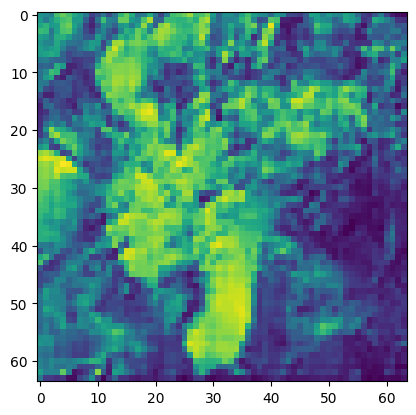

In [65]:
# Sample output from the Generator
noise = tf.random.normal([1, 100])
generated_image = generator((noise,caption_embeddings[5].reshape(1,300)), training=False)

plt.imshow(generated_image[0, :, :, 0])

In [66]:
# Initlializing a discriminator
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator_func(image_shape,EMBEDDING_SIZE)
#discriminator.load_weights("flowers/discriminator_weights.h5")
discriminator.load_weights('flowers/model/discriminator_weights_epoch_500.h5')

In [43]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   1568        ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu_5 (LeakyReLU)      (None, 32, 32, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 32, 32, 32)   0           ['leaky_re_lu_5[0][0]']          
                                                                                            

In [67]:
decision = discriminator((generated_image,caption_embeddings[5].reshape(1,300)))
print(decision)

tf.Tensor([[0.2510952]], shape=(1, 1), dtype=float32)


In [68]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_image_real_text, fake_image_real_text, real_image_fake_text):
    real_loss = cross_entropy(tf.random.uniform(real_image_real_text.shape,0.8,1.0), real_image_real_text)
    fake_loss = (cross_entropy(tf.random.uniform(fake_image_real_text.shape,0.0,0.2), fake_image_real_text) + 
                 cross_entropy(tf.random.uniform(real_image_fake_text.shape,0.0,0.2), real_image_fake_text))/2

    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Both the generator and discriminator use Adam and the same learning rate and momentum.  This does not need to be the case.  If you use a **GENERATE_RES** greater than 3 you may need to tune these learning rates, as well as other training and hyperparameters.  

In [69]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=2e-4,
#     decay_steps=100,
#     decay_rate=0.5)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2.0e-4,beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2.0e-4,beta_1 = 0.5)

## Training

In [70]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,captions,fake_captions):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE],dtype=tf.float32)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator((seed,captions), training=True)
    real_image_real_text = discriminator((images,captions), training=True)
    real_image_fake_text = discriminator((images,fake_captions), training=True)
    fake_image_real_text = discriminator((generated_images,captions), training=True)

    gen_loss = generator_loss(fake_image_real_text)
    disc_loss = discriminator_loss(real_image_real_text, fake_image_real_text, real_image_fake_text)
    # print(gen_loss)
    # print(disc_loss)

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [71]:
# Function that executes trianing process
def train(train_dataset, epochs,generator, discriminator,start_epoch):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  fixed_embed = save_images_embeddings

  start = time.time()

  for epoch in range(start_epoch,epochs):
    print("epoch start...")
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for batch in train_dataset[:-1]:
      # train_batch = training_data[BATCH_SIZE*image_batch : BATCH_SIZE*image_batch + BATCH_SIZE]
      # caption_batch = captions[BATCH_SIZE*image_batch : BATCH_SIZE*image_batch + BATCH_SIZE]
      train_batch = batch['images']
      caption_batch = batch['embeddings']
      
      fake_caption_batch = np.copy(caption_batch)
      np.random.shuffle(fake_caption_batch)
      
      t = train_step(train_batch,caption_batch,fake_caption_batch)
      # print(t)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])
      # if image_batch%50 == 0:
      #   print(image_batch)
      # print("here")
    print("now")
    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print(f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed,fixed_embed)
    

    generator.save_weights('flowers/model/generator_weights_epoch_{}.h5'.format(epoch+1))
    discriminator.save_weights('flowers/model/discriminator_weights_epoch_{}.h5'.format(epoch+1))

  elapsed = time.time()-start
  print ('Training time:', hms_string(elapsed))


In [ ]:
train(list(train_dataset.as_numpy_iterator()), 600,generator,discriminator,500)

epoch start...


2023-03-28 21:57:51.714791: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


now
Epoch 501, gen loss=1.1427712440490723,disc loss=1.2083364725112915, 0:00:32.98
1/1 [==============================] - 0s 174ms/step
epoch start...
now
Epoch 502, gen loss=1.1532042026519775,disc loss=1.148106336593628, 0:00:26.37
1/1 [==============================] - 0s 20ms/step
epoch start...
now
Epoch 503, gen loss=1.272729754447937,disc loss=1.1000423431396484, 0:00:26.74
1/1 [==============================] - 0s 20ms/step
epoch start...
now
Epoch 504, gen loss=1.251651644706726,disc loss=1.1003278493881226, 0:00:27.05
1/1 [==============================] - 0s 20ms/step
epoch start...
now
Epoch 505, gen loss=1.1798826456069946,disc loss=1.102879524230957, 0:00:27.32
1/1 [==============================] - 0s 20ms/step
epoch start...
now
Epoch 506, gen loss=1.2025573253631592,disc loss=1.1099823713302612, 0:00:27.61
1/1 [==============================] - 0s 21ms/step
epoch start...
now
Epoch 507, gen loss=1.1687029600143433,disc loss=1.1180901527404785, 0:00:27.90
1/1 [========

## Results

In [50]:
save_images_embeddings.shape

(28, 300)

In [51]:
# Printing the captions
save_images_captions

['prominentpurplestigma,petalsarewhiteincolor',
 'thisfloweriswhiteandpurpleincolor,withpetalsthatareovalshaped.',
 'thisflowerhaspetalsthatarepinkwithstringywhitestamen',
 'thisfloweriswhiteandpurpleincolor,withpetalsthatareovalshaped.',
 'purpleflowerwithcurvystring-likepetalsandagroupoflargeyellowstameninthecenter.',
 'thepetalsoftheflowerarepinkincolorandhavefilamentsthatarepinkincolor.',
 'thisflowerhaslongthinpetalsthatareblackatthebase,whiteatthecenter,andblueatthetips.',
 'theflowerhaswhiteandpurplepetals,withtheyellowstamenclearlyvisible.',
 'thisflowerhaspetalsthatarepurplewithgreensteman',
 'thepetalsoftheflowerarepurpleincolorwiththinpurplefilaments.',
 'thisfloweriswhiteandpurpleincolor,withpetalsthatareovalshaped.',
 'thisflowerhasthickgreenstamenandpurplefringesurroundedbywidewhitepetalswithpointedtips.',
 'thisuniqueflowerhasastrangesetofpistilandstamenwithwhite-pinkpetals.',
 'thepetalsonthisflowerarenumerouscolors:greenwhite,purple,andbrown.',
 'thisisastrangeflowerwi

In [52]:
def test_image(text,num):
  test_embeddings = np.zeros((1,300),dtype=np.float32)

  x = text.lower()
  x = x.replace(" ","")
  count = 0
  for t in x:
    try:
      test_embeddings[0] += glove_embeddings[t]
      count += 1
    except:
      print(t)
      pass
  test_embeddings[0] /= count
  test_embeddings =  np.repeat(test_embeddings,[28],axis=0)
  noise = tf.random.normal([28, 100])
  save_images(num,noise,test_embeddings)

In [53]:
test_image("this flower is purple in color with oval shaped petals",700)

1/1 [==============================] - 0s 20ms/step


In [62]:
!pip install ipython

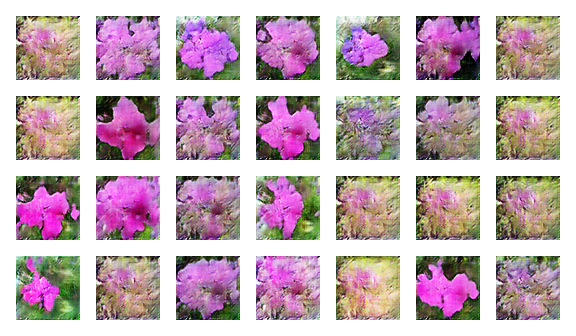

In [54]:
import IPython
IPython.display.Image('flowers/output_64_character_extended/train-700.png')

In [55]:
test_image("this flower is yellow in color with oval shaped petals",710)

1/1 [==============================] - 0s 19ms/step


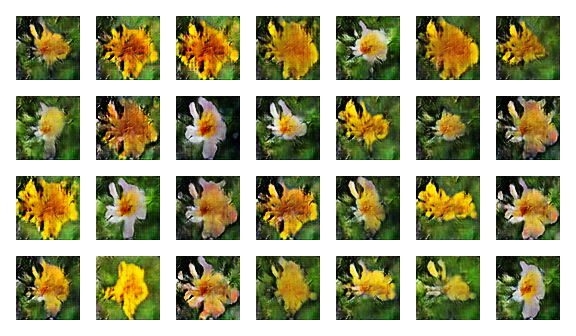

In [56]:
import IPython
IPython.display.Image('flowers/output_64_character_extended/train-710.png')

In [55]:
test_image("this flower is pink in color with oval shaped petals",3)

1/1 [==============================] - 0s 20ms/step


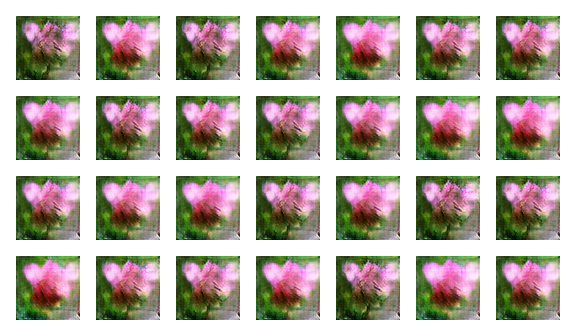

In [56]:
import IPython
IPython.display.Image('flowers/output_64_character_extended/train-3.png')

In [57]:
test_image("this flower is red in color with circle shaped petals",720)

1/1 [==============================] - 0s 19ms/step


Code Reference:
https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_2_Keras_gan.ipynb

Paper Reference:
https://arxiv.org/pdf/1605.05396.pdf

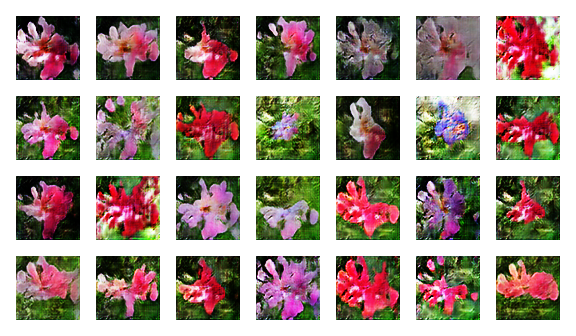

In [58]:
import IPython
IPython.display.Image('flowers/output_64_character_extended/train-720.png')

1/1 [==============================] - 0s 20ms/step


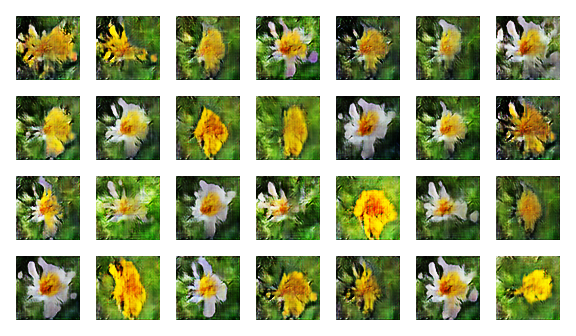

In [62]:
test_image("this flower is blue in color",730)
IPython.display.Image('flowers/output_64_character_extended/train-730.png')

1/1 [==============================] - 0s 20ms/step


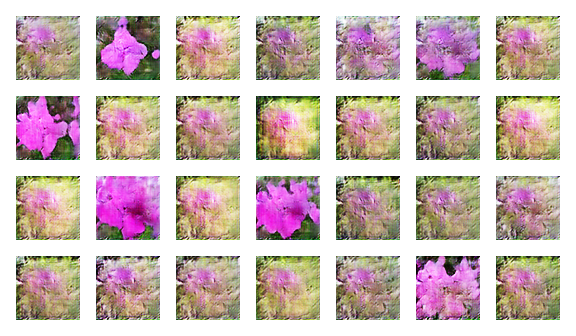

In [63]:
test_image("prominent purple stigma,petals are white in color",6)
IPython.display.Image('flowers/output_64_character_extended/train-6.png')

1/1 [==============================] - 0s 20ms/step


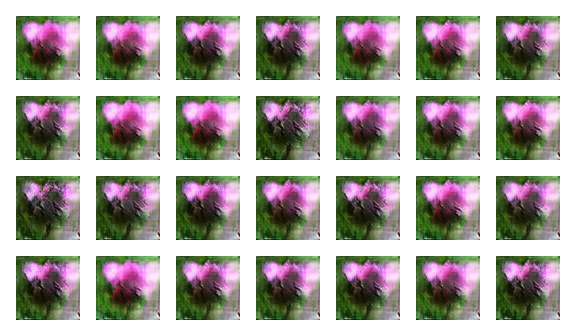

In [61]:
test_image("prominent purple stigma,petals are black in color",401)
IPython.display.Image('flowers/output_64_character_extended/train-401.png')